# Debug

## Setup

In [1]:
from math import sin, cos, ceil, sqrt
from functools import reduce
import time
import typing
import torch
import torchvision
import matplotlib.pyplot as plt
import torch_radon
import radon

In [2]:
def shepp_logan_phantom(n: int) -> torch.Tensor:
    phantom = torch.zeros((n,n))
    centers = torch.tensor([[0, 0], [0, -0.0184], [0.11, 0], [-0.11, 0], [0, 0.175], [0, 0.05], [0, -0.05], [-0.04, -0.3025], [0, -0.3025], [0.03, -0.3025]])
    axes = torch.tensor([[0.69, 0.92], [0.6624, 0.874], [0.11, 0.31], [0.16, 0.41], [0.21, 0.25], [0.046, 0.046], [0.046, 0.046], [0.046, 0.023], [0.023, 0.023], [0.023, 0.046]])
    theta = torch.tensor([0, 0, -0.31415926535, 0.31415926535, 0, 0, 0, 0, 0, 0])
    intensity = torch.tensor([2, -1.0, -0.2, -0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
    x,y = torch.meshgrid(torch.linspace(-0.5, 0.5, n), -torch.linspace(-0.5, 0.5, n), indexing="ij")
    with torch.no_grad():
        for i in range(10):
            phantom[
                torch.square((x-centers[i,0])*cos(theta[i])+(y-centers[i,1])*sin(theta[i]))/((axes[i,0]/2.0)**2)+
                torch.square((x-centers[i,0])*sin(theta[i])-(y-centers[i,1])*cos(theta[i]))/((axes[i,1]/2.0)**2)
                <= 1.0] += intensity[i]
    return phantom.T/2.0

## Stuff

### Filtered backprojection

In [3]:
dev = "cuda"

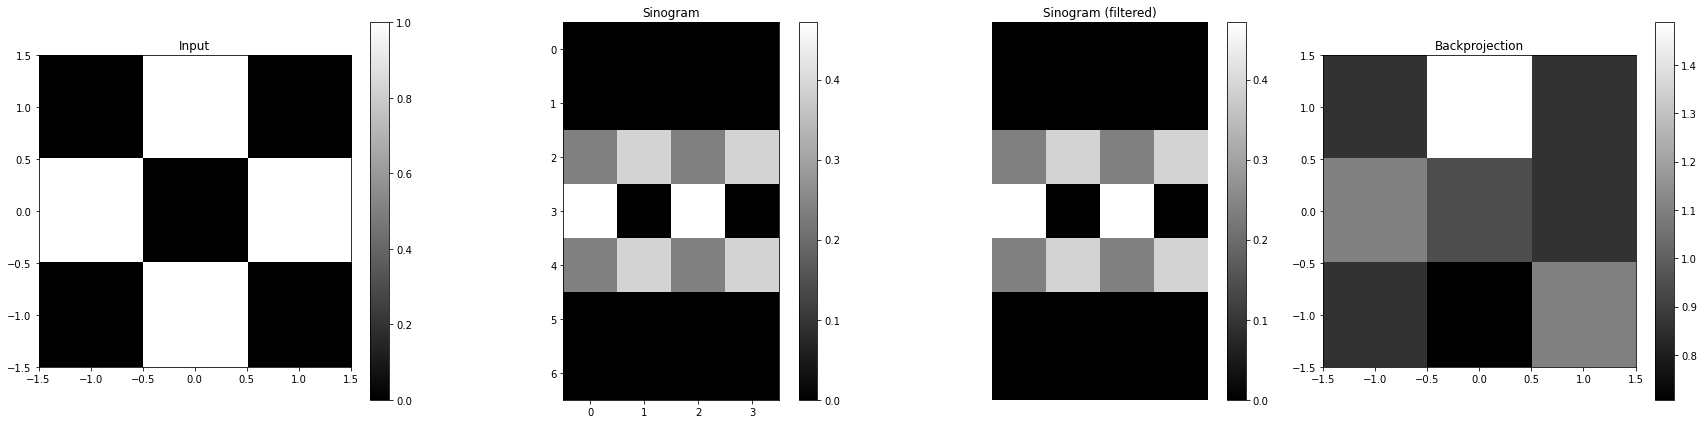

ValueError: num must be 1 <= num <= 4, not 5

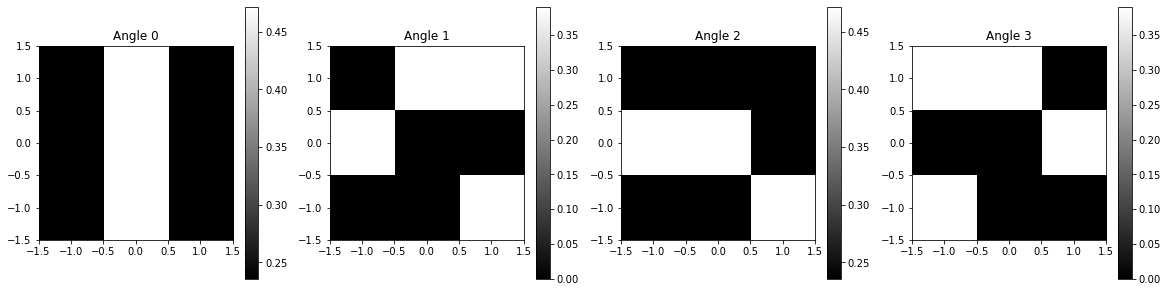

In [12]:
size2 = 3
img = torch.zeros((size2*size2), device=dev)
img[1::2] = 1.0
img = img.reshape(1,1,size2,size2)
#img = shepp_logan_phantom(200).contiguous().unsqueeze(0).unsqueeze(0).to("cuda").requires_grad_(True)
angles = torch.linspace(0.0, torch.pi, 4+1, device=img.device)[:-1]
M = ceil(img.shape[2]*1.41421356237/2.0)
positions = torch.arange(-M, M+1, device=img.device).to(torch.float32)

plt.subplots(1, 4, figsize=(24,6))
plt.subplot(1, 4, 1)
plt.title("Input")
plt.imshow(img[0,0].detach().to("cpu"), cmap="gray", extent=(-img.shape[-1]/2.0, img.shape[-1]/2.0, -img.shape[-1]/2.0, img.shape[-1]/2.0))
plt.colorbar()
sino = radon.radon_forward(img, angles, positions)
plt.subplot(1, 4, 2)
plt.title("Sinogram")
plt.imshow(sino[0,0].detach().to("cpu").mT, cmap="gray")
plt.colorbar()
fsino = sino#radon.radon_filter(sino, radon.ram_lak_filter, None)
plt.subplot(1, 4, 3)
plt.gca().set_axis_off()
plt.subplot(1, 4, 3)
plt.title("Sinogram (filtered)")
plt.imshow(fsino[0,0].detach().to("cpu").mT, cmap="gray")
plt.colorbar()
recon = radon.radon_backward(fsino, img.shape[3], angles, positions)
plt.subplot(1, 4, 4)
plt.title("Backprojection")
plt.imshow(recon[0,0].detach().to("cpu"), cmap="gray", extent=(-img.shape[-1]/2.0, img.shape[-1]/2.0, -img.shape[-1]/2.0, img.shape[-1]/2.0)) 
plt.colorbar()
plt.tight_layout()
plt.show()
plt.subplots(ceil(angles.shape[0]/5), min(5, angles.shape[0]), figsize=(5*min(5, angles.shape[0]), 5*ceil(angles.shape[0]/5)))
for i in range(angles.shape[0]):
    plt.subplot(ceil(angles.shape[0]/5), min(5, angles.shape[0]), i+1)
    plt.title(f"Angle {i}")
    recon = radon.radon_backward(fsino[..., i:i+1, :], img.shape[3], angles[i:i+1], positions)
    plt.imshow(recon[0,0].detach().to("cpu"), cmap="gray", extent=(-img.shape[-1]/2.0, img.shape[-1]/2.0, -img.shape[-1]/2.0, img.shape[-1]/2.0))
    #print(recon[0,0])
    plt.colorbar()
if angles.shape[0] > 5:
    for i in range(ceil(angles.shape[0]/5)*5-angles.shape[0]):
        plt.subplot(ceil(angles.shape[0]/5), min(5, angles.shape[0]), angles.shape[0]+i+1)
        plt.gca().set_axis_off()
plt.tight_layout()
plt.show()

### Filtered layergram

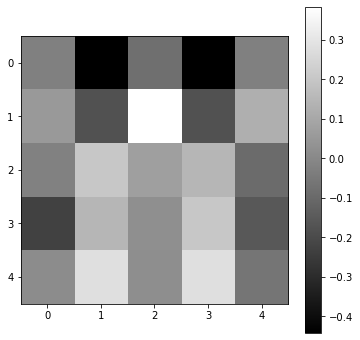

In [5]:
plt.subplots(1,1,figsize=(6,6))
x, y = torch.meshgrid(torch.fft.fftfreq(size2, dtype=torch.float32, device=dev), torch.fft.fftfreq(size2, dtype=torch.float32, device=dev), indexing="xy")
filter_ = torch.sqrt(x**2+y**2)
plt.imshow(filter_.to("cpu"))
fft_bp = torch.fft.fft2(radon.radon_backward(sino.to(dev), 5, angles.to(dev), positions.to(dev)), norm="ortho")
recon = torch.fft.ifft2(filter_*fft_bp, norm="ortho").real
plt.imshow(recon[0,0].to("cpu"), cmap="gray")
plt.colorbar()
plt.show()

### Matrix multiplication

In [6]:
#dev = "cuda"
#matrix = radon.radon_impl._impl.matrix_backward(torch.randn((1,1,3,3)), angles.to("cpu"), positions.to("cpu"), 3).to(dev)
#plt.imshow(matrix[0,0].to("cpu"))
#plt.show()
#
#img = torch.tensor([[0.0,1.0,0.0],[1.0,0.0,1.0],[0.0,1.0,0.0]]).reshape(1,1,3,3).to(dev)
#plt.subplots(1, 4, figsize=(24,6))
#plt.subplot(1, 4, 1)
#plt.title("Input")
#plt.imshow(img[0,0].detach().to("cpu"), cmap="gray", extent=(-img.shape[-1]/2.0, img.shape[-1]/2.0, -img.shape[-1]/2.0, img.shape[-1]/2.0))
#plt.colorbar()
#angles = torch.linspace(0.0, torch.pi, 5, device=img.device)[:-1]
#M = ceil(img.shape[2]*1.41421356237/2.0)
#positions = torch.arange(-M, M+1, device=img.device).to(torch.float32)
#sino = radon.radon_forward(img, angles, positions)
#plt.subplot(1, 4, 2)
#plt.title("Sinogram")
#plt.imshow(sino[0,0].detach().to("cpu").mT, cmap="gray")
#plt.colorbar()
#fsino = radon.radon_filter(sino, radon.ram_lak_filter, None)
#plt.subplot(1, 4, 3)
#plt.gca().set_axis_off()
#plt.subplot(1, 4, 3)
#plt.title("Sinogram (filtered)")
#plt.imshow(fsino[0,0].detach().to("cpu").mT, cmap="gray")
#plt.colorbar()
#recon = (matrix@sino.reshape(1,1,-1,1)).reshape(1,1,3,3)
#plt.subplot(1, 4, 4)
#plt.title("Backprojection")
#plt.imshow(recon[0,0].detach().to("cpu"), cmap="gray", extent=(-img.shape[-1]/2.0, img.shape[-1]/2.0, -img.shape[-1]/2.0, img.shape[-1]/2.0)) 
#plt.colorbar()
#plt.tight_layout()
#plt.show()
#
#plt.subplots(1, angles.shape[0], figsize=(5*angles.shape[0], 5))
#for i in range(angles.shape[0]):
#    plt.subplot(1, angles.shape[0], i+1)
#    plt.title(f"Angle {i}")
#    recon = (matrix@torch.cat((torch.zeros((1,1,positions.shape[0]*i,1), device=dev), fsino[:,:,i:i+1,:].reshape(1,1,positions.shape[0],1), torch.zeros((1,1,positions.shape[0]*(angles.shape[0]-1-i),1), device=dev)), dim=2)).reshape(1,1,3,3)
#    plt.imshow(recon[0,0].detach().to("cpu"), cmap="gray", extent=(-img.shape[-1]/2.0, img.shape[-1]/2.0, -img.shape[-1]/2.0, img.shape[-1]/2.0))
#    plt.colorbar()
#plt.tight_layout()
#plt.show()

### Transpose check

In [7]:
positions = torch.arange(-ceil(32*1.41421356237/2.0), ceil(32*1.41421356237/2.0)+1, dtype=torch.float32, device=dev)
angles = torch.linspace(0.0, torch.pi, 33, device=dev)[:-1]
a = torch.randn((1,1,32,32), device=dev)
b = torch.randn((1,1,angles.shape[0],positions.shape[0]), device=dev)
Aa = radon.radon_forward(a, angles, positions)
Atb = radon.radon_backward(b, 32, angles, positions)
print(f"<Aa,b>:    {torch.sum(Aa*b).item():.5f}")
print(f"<a,A^Tb>:  {torch.sum(a*Atb).item():.5f}")
print(f"Ratio:     {torch.sum(Aa*b).item()/torch.sum(a*Atb).item():.5f}")

<Aa,b>:    1.42391
<a,A^Tb>:  200.93956
Ratio:     0.00709


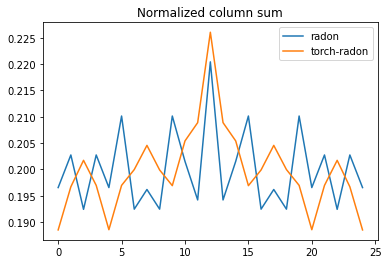

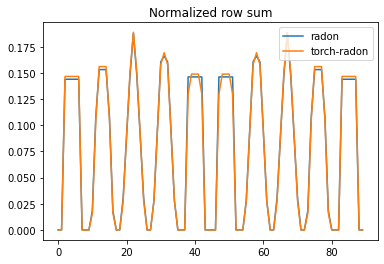

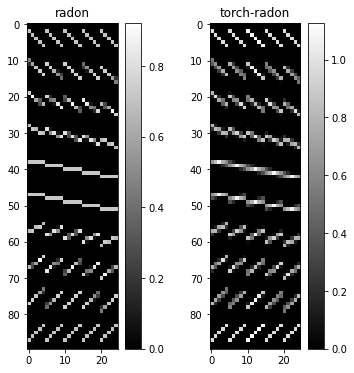

In [8]:
size2 = 5
angle_count2 = 10
angles2 = torch.linspace(0.0, torch.pi, angle_count2, device="cuda")
positions2 = torch.arange(-ceil(size2*sqrt(2.0)/2.0), ceil(size2*sqrt(2.0)/2.0)+1, dtype=torch.float32, device="cuda")
torchradon2 = torch_radon.Radon(size2, angles2, positions2.shape[0])

radon_matrix2 = torch.zeros((size2*size2,angle_count2*(2*ceil(size2*sqrt(2)/2)+1)), device=dev)
torchradon_matrix2 = torch.zeros((size2*size2,angle_count2*(2*ceil(size2*sqrt(2)/2)+1)), device="cuda")

for i in range(size2*size2):
    img2 = torch.zeros((1,1,size2,size2), device="cuda")
    img2[0,0,i//size2,i%size2] = 1.0
    radon_matrix2[i] = radon.radon_forward(img2.to(dev), angles2.to(dev), positions2.to(dev)).flatten()
    torchradon_matrix2[i] = torchradon2.forward(img2).flatten()
radon_matrix2 *= size2

normalize2 = True
plt.title(("Normalized c" if normalize2 else "C")+"olumn sum")
plt.plot((torch.nn.functional.normalize(radon_matrix2.sum(1), dim=0) if normalize2 else radon_matrix2.sum(1)).detach().to("cpu").numpy(), label="radon")
plt.plot((torch.nn.functional.normalize(torchradon_matrix2.sum(1), dim=0) if normalize2 else torchradon_matrix2.sum(1)).detach().to("cpu").numpy(), label="torch-radon")
plt.legend()
plt.show()
plt.title(("Normalized r" if normalize2 else "R")+"ow sum")
plt.plot((torch.nn.functional.normalize(radon_matrix2.sum(0), dim=0) if normalize2 else radon_matrix2.sum(0)).detach().to("cpu").numpy(), label="radon")
plt.plot((torch.nn.functional.normalize(torchradon_matrix2.sum(0), dim=0) if normalize2 else torchradon_matrix2.sum(0)).detach().to("cpu").numpy(), label="torch-radon")
plt.legend()
plt.show()

plt.subplots(1,2,figsize=(6,6))
plt.subplot(1,2,1)
plt.title("radon")
plt.imshow(radon_matrix2.detach().to("cpu").mT.numpy(), cmap="gray")
plt.colorbar()
plt.subplot(1,2,2)
plt.title("torch-radon")
plt.imshow(torchradon_matrix2.detach().to("cpu").flip(1).mT.numpy(), cmap="gray")
plt.colorbar()
plt.show()

/home/alexander/anaconda3/envs/FSDLIP/lib/python3.10/site-packages/torch_radon-1.0.0-py3.10-linux-x86_64.egg/torch_radon/__init__.py:108: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484803030/work/aten/src/ATen/native/Copy.cpp:250.)
  return filtered_sinogram.to(dtype=sinogram.dtype)


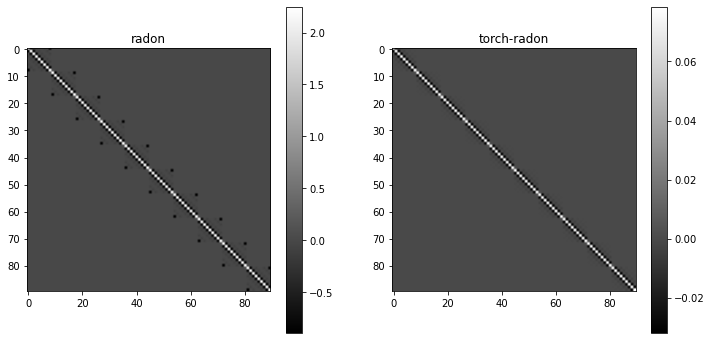

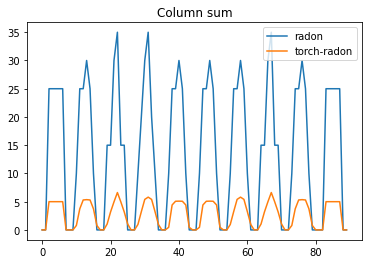

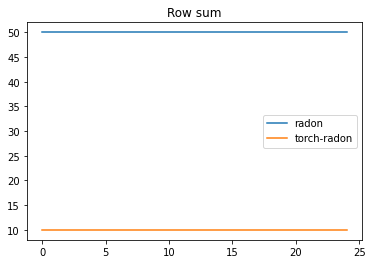

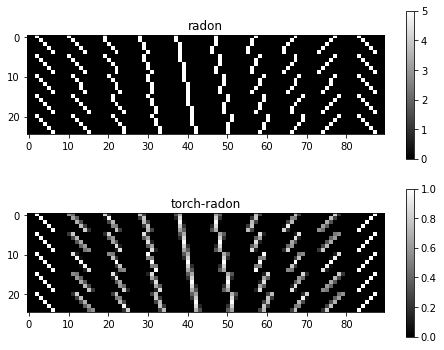

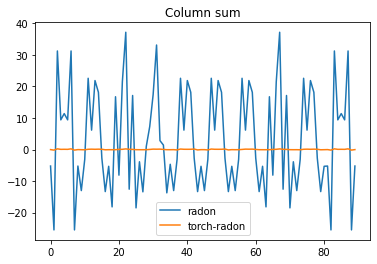

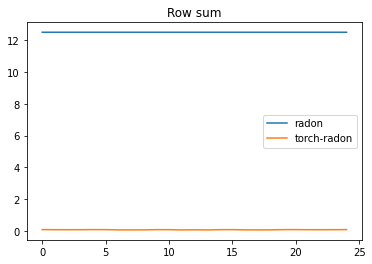

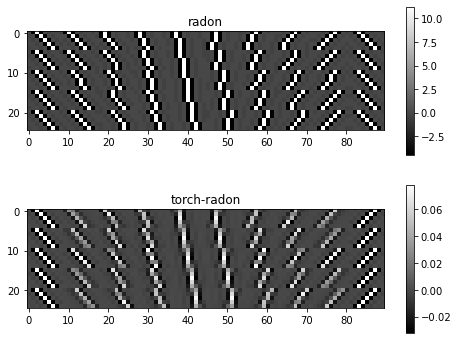

In [9]:
size3 = 5
angle_count3 = 10
angles3 = torch.linspace(0.0, torch.pi, angle_count3, device="cuda")
positions3 = torch.arange(-ceil(size3*sqrt(2.0)/2.0), ceil(size3*sqrt(2.0)/2.0)+1, dtype=torch.float32, device="cuda")
torchradon3 = torch_radon.Radon(size3, angles3, positions3.shape[0])

radon_matrix3 = torch.zeros((angle_count3*(2*ceil(size3*sqrt(2)/2)+1),size3*size3), device=dev)
torchradon_matrix3 = torch.zeros((angle_count3*(2*ceil(size3*sqrt(2)/2)+1),size3*size3), device="cuda")
radon_filter_matrix3 = torch.zeros((angle_count2*(2*ceil(size2*sqrt(2)/2)+1),angle_count2*(2*ceil(size2*sqrt(2)/2)+1)), device=dev)
torchradon_filter_matrix3 = torch.zeros((angle_count2*(2*ceil(size2*sqrt(2)/2)+1),angle_count2*(2*ceil(size2*sqrt(2)/2)+1)), device="cuda")

for i in range(angles3.shape[0]*positions3.shape[0]):
    sino3 = torch.zeros((1,1,angles3.shape[0],positions3.shape[0]), device="cuda")
    sino3[0,0,i//positions3.shape[0],i%positions3.shape[0]] = 1.0
    radon_matrix3[i] = radon.radon_backward(sino3.to(dev), size3, angles3.to(dev), positions3.to(dev)).flatten()
    torchradon_matrix3[i] = torchradon3.backprojection(sino3).flatten()
radon_matrix3 *= size3

for i in range(angles3.shape[0]*positions3.shape[0]):
    sino3 = torch.zeros((1,1,angles3.shape[0],positions3.shape[0]), device="cuda")
    sino3[0,0,i//positions3.shape[0],i%positions3.shape[0]] = 1.0
    radon_filter_matrix3[i] = radon.radon_filter(sino3.to(dev), radon.ram_lak_filter).flatten()
    torchradon_filter_matrix3[i] = torchradon3.filter_sinogram(sino3, "ram-lak").flatten()

plt.subplots(1,2,figsize=(12,6))
plt.subplot(1,2,1)
plt.title("radon")
plt.imshow(radon_filter_matrix3.detach().to("cpu").mT.numpy(), cmap="gray")
plt.colorbar()
plt.subplot(1,2,2)
plt.title("torch-radon")
plt.imshow(torchradon_filter_matrix3.detach().to("cpu").mT.numpy(), cmap="gray")
plt.colorbar()
plt.show()

normalize3 = False
plt.title(("Normalized c" if normalize3 else "C")+"olumn sum")
plt.plot((torch.nn.functional.normalize(radon_matrix3.sum(1), dim=0) if normalize3 else radon_matrix3.sum(1)).detach().to("cpu").numpy(), label="radon")
plt.plot((torch.nn.functional.normalize(torchradon_matrix3.sum(1), dim=0) if normalize3 else torchradon_matrix3.sum(1)).detach().to("cpu").numpy(), label="torch-radon")
plt.legend()
plt.show()
plt.title(("Normalized r" if normalize3 else "R")+"ow sum")
plt.plot((torch.nn.functional.normalize(radon_matrix3.sum(0), dim=0) if normalize3 else radon_matrix3.sum(0)).detach().to("cpu").numpy(), label="radon")
plt.plot((torch.nn.functional.normalize(torchradon_matrix3.sum(0), dim=0) if normalize3 else torchradon_matrix3.sum(0)).detach().to("cpu").numpy(), label="torch-radon")
plt.legend()
plt.show()

plt.subplots(2,1,figsize=(8,6))
plt.subplot(2,1,1)
plt.title("radon")
plt.imshow(radon_matrix3.detach().to("cpu").mT.numpy(), cmap="gray")
plt.colorbar()
plt.subplot(2,1,2)
plt.title("torch-radon")
plt.imshow(torchradon_matrix3.detach().to("cpu").mT.flip(1).numpy(), cmap="gray")
plt.colorbar()
plt.show()

plt.title(("Normalized c" if normalize3 else "C")+"olumn sum")
plt.plot((torch.nn.functional.normalize((radon_filter_matrix3@radon_matrix3).sum(1), dim=0) if normalize3 else (radon_filter_matrix3@radon_matrix3).sum(1)).detach().to("cpu").numpy(), label="radon")
plt.plot((torch.nn.functional.normalize((torchradon_filter_matrix3@torchradon_matrix3).sum(1), dim=0) if normalize3 else (torchradon_filter_matrix3@torchradon_matrix3).sum(1)).detach().to("cpu").numpy(), label="torch-radon")
plt.legend()
plt.show()
plt.title(("Normalized r" if normalize3 else "R")+"ow sum")
plt.plot((torch.nn.functional.normalize((radon_filter_matrix3@radon_matrix3).sum(0), dim=0) if normalize3 else (radon_filter_matrix3@radon_matrix3).sum(0)).detach().to("cpu").numpy(), label="radon")
plt.plot((torch.nn.functional.normalize((torchradon_filter_matrix3@torchradon_matrix3).sum(0), dim=0) if normalize3 else (torchradon_filter_matrix3@torchradon_matrix3).sum(0)).detach().to("cpu").numpy(), label="torch-radon")
plt.legend()
plt.show()

plt.subplots(2,1,figsize=(8,6))
plt.subplot(2,1,1)
plt.title("radon")
plt.imshow((radon_filter_matrix3@radon_matrix3).detach().to("cpu").mT.numpy(), cmap="gray")
plt.colorbar()
plt.subplot(2,1,2)
plt.title("torch-radon")
plt.imshow((torchradon_filter_matrix3@torchradon_matrix3).detach().to("cpu").mT.flip(1).numpy(), cmap="gray")
plt.colorbar()
plt.show()